# Topic modeling

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LsiModel, LdaModel, HdpModel
import pyLDAvis.gensim

from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')

In [18]:
df = pd.read_excel('RealEstate.xlsx')
df

,web_id,property_text_en
0,7023850,Smart Business Real Estate is proud to present...
1,6905802,My Island Real Estate is proud to present 1 Be...
2,6998469,"New on the market, amazing opportunity for inv..."
3,6766136,1 Bedroom Apartment in Marina Diamond 2\n\n- 1...
4,6940244,No penalty for early contract termination!<br ...
...,...,...
756,6203680,Castles Plaza Real Estate is pleased to bring ...
757,7090736,The Noble House Real Estate is proud to presen...
758,7081426,Better Homes would like to present this type 2...
759,7123539,Morgan‚Äôs International Realty is proud to pr...


## Part 1

#### Inspecting the first 8 entries

In [19]:
# Inspecting the first 8 entries
for entry in df.loc[0:8,'property_text_en']:
    print(entry)
    print()
    print()

Smart Business Real Estate is proud to present2Bedrooms for sale locatedat Dubai MarinaElite Residenceon mid floor over looking court yard.\n\nProperty currently Rentedat AED 110,000 till25 of June 2020.\n\nElite Residenceis ideally locatedat the middle of Dubai Marina area , close to the Tran stationas well Metro stationnear by .surrounding by lots of cafe and restaurants , Marina Walkpromenade , across streetfew5 *Hotels. Dubai Marinais very popularand most desirable place to live.\n\nAt the building available facilities:\nGym\nPool\nSecurity 24/7\nCovered parking .\n\nFor more information or viewing appointment, call:\nSmart Business Real Estate LLC\nLandline:+971 4 5808525 / 0503474100\nEmail: info@sbrealestate.ae\nBRN 11575\nORN 2104


My Island Real Estate is proud to present 1 Bedroom Apt. in Dubai Marina with Partial Sea View\n\n\nDubai Marina\nPrincess Tower\n1 Bedroom Apartment\nPartial Sea View\n922.68 sqft\nUnfurnished Apartment\n\n\n\nFor more details, please call 056-9576

#### Here we notice the text includes a lot of:
- html
- '\n' which means new line
- phone numbers starting with + sign 
    - many formats
    - +xxx xx xxx xxxx
    - +xxx x xxx xxxx
    - +xxxxxxxxxxxx
    - xxxxx (continuous block of numbers)
    - xxxx,xxxx
- special characters
- emails

So we need to preprocess the data and clean it

### Method for getting the relevant pos tag

In [20]:
from nltk.corpus import wordnet
# method used to get the correct pos tag for correct lemmatization since nltk assumes all words are nouns which results in wrong lemmatization without specifying the correct pos
def get_pos(word):
    # WordNet Lemmatizer needs a pos to correctly lemmatize words. 
    # WordNet accepts pos in formats: 'wordnet.NOUN' 'wordnet.VERB' 'wordnet.ADJ' 'wordnet.ADV' for noun, verb, adj, adverb, respectively
    # to map nltk pos tags to wordnet pos tags we get the first letter out of the nltk pos tag and map it to a wordnet tag

    # get the nltk pos tag 
    pos = nltk.pos_tag([word])
    #outputs: [('playing', 'VBG')]

    # get the first letter of the nltk pos tag
    pos = pos[0][1][0]

    pos_tags = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "J": wordnet.ADJ,
        "R": wordnet.ADV,
        "default": wordnet.NOUN
    }
    # if the pos tag doesnt match any key, return wordnet.NOUN as a default
    return pos_tags.get(pos, pos_tags['default'])
    


### Method for preprocessing each document

In [21]:

def preprocessing(document):
    document = document.lower()

    #removing the html
    document = re.sub(r'(\<[ ]?[a-z]+>|\<\/[a-z]+\>)', ' ', document)
    # noticed that '<' stayed for some reason, so removing them
    document = re.sub(r'<', ' ', document)
    
    # removing emails
    document = re.sub(r'\S+@\S+', ' ', document)
    # removing \n
    document = re.sub(r'(\\n)', " ", document)
    # removing numbers of this formats:
    # - xxxx,xxxx (numbers with commas)
    document = re.sub(r'(\d+),(\d+),?(\d*)', " ", document)
    # removing numbers of all other formats
    document = re.sub(r'(\+)?\d+[ ]?\d*[ ]?\d*[ ]?\d*', ' ', document)
    # removing characters like ? ! : ; \n \
    document = re.sub('[*.?!,:;/&]', ' ', document)
    # removal of --
    document = re.sub(r'--'," ", document)

    document = " ".join([word for word in document.split() if len(word) > 3 ])
    
    document = " ".join([word for word in document.split() if word not in stop_words])
    
    document = " ".join([WordNetLemmatizer().lemmatize(word, get_pos(word)) for word in document.split()])
    
    return document

In [22]:
# example of lemmatization
word = WordNetLemmatizer().lemmatize('being', pos=wordnet.VERB)
word

'be'

In [23]:
# apply the method on the documents column
df['property_text_en'] = df['property_text_en'].apply(preprocessing)


Lets see how the text changed after preprocessing

In [24]:
for document in df.loc[0:8,'property_text_en']:
    print(document)
    print()
    print()

smart business real estate proud present bedroom sale locatedat dubai marinaelite residenceon floor look court yard property currently rentedat till june elite residenceis ideally locatedat middle dubai marina area close tran stationas well metro stationnear surround lot cafe restaurant marina walkpromenade across streetfew hotel dubai marinais popularand desirable place live building available facility pool security cover parking information view appointment call smart business real estate landline email


island real estate proud present bedroom dubai marina partial view dubai marina princess tower bedroom apartment partial view sqft unfurnished apartment detail please call email marina dubai marina awe-inspiring city-within-a city delight resident cosmopolitan free-spirited atmosphere unique invigorate lifestyle urban center water comparable exclusive waterfront development world lead city unlike anywhere else dubai middle east even world island real estate island real estate indepe

In [25]:
text = df['property_text_en'].tolist()
text_tokenized = [nltk.word_tokenize(doc) for doc in text]

In [26]:
# preparing inputs for the LSI model
dictionary = corpora.Dictionary(text_tokenized)

In [27]:
corpus = [dictionary.doc2bow(doc) for doc in text_tokenized]
# document-term frequency for first 2 documents
for doc in corpus[0:2]:
    print(doc,'\n')
# (0,1) -> word-id 0 occurs 1 time in the first document

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)] 

[(4, 2), (6, 1), (8, 1), (14, 5), (16, 1), (17, 5), (29, 4), (33, 1), (38, 1), (40, 1), (41, 5), (55, 2), (57, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (

### Initializing the LSI model

In [28]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

### Inspecting the U matrix

In [29]:
u_df = pd.DataFrame(data= lsimodel.projection.u)
# sort by column 0
u_df.sort_values(axis= 0, by= 0, ascending= False)

,0,1,2,3,4,5,6,7,8,9
14,0.395613,0.306555,-0.179144,0.164522,0.092399,0.356009,-0.201622,0.236517,-0.142686,0.084138
29,0.383955,0.362388,-0.303772,0.151926,-0.166643,-0.170025,0.110146,0.024499,0.022655,0.123761
55,0.232085,-0.187971,0.000203,0.023972,-0.031580,-0.228500,-0.211596,-0.221333,-0.127138,-0.133788
64,0.217057,0.077602,-0.064342,0.012141,-0.143101,-0.010256,-0.163926,-0.481295,0.184815,-0.002201
106,0.212777,0.200079,0.507521,0.156108,-0.025252,-0.146596,-0.013214,0.135885,0.102641,-0.083889
...,...,...,...,...,...,...,...,...,...,...
2528,0.000030,-0.000236,-0.000046,0.000150,0.000028,-0.000196,-0.000210,-0.000026,-0.000466,-0.000351
2529,0.000030,-0.000236,-0.000046,0.000150,0.000028,-0.000196,-0.000210,-0.000026,-0.000466,-0.000351
2530,0.000030,-0.000236,-0.000046,0.000150,0.000028,-0.000196,-0.000210,-0.000026,-0.000466,-0.000351
2531,0.000030,-0.000236,-0.000046,0.000150,0.000028,-0.000196,-0.000210,-0.000026,-0.000466,-0.000351


We can see here that the words with ids 14,29,55 relate most to topic 0

In [30]:
ids = [14,29,55]
for id in ids:
    print(f'word with id {id} is: {dictionary[id]}')

word with id 14 is: dubai
word with id 29 is: marina
word with id 55 is: view


Which does make sense, since those words appear a lot in the corpus

### Inspecting the S matrix

In [31]:
s_df = pd.DataFrame(data= lsimodel.projection.s)
s_df

,0
0,199.764581
1,72.147968
2,67.471718
3,62.997631
4,55.209463
5,48.759345
6,45.512758
7,43.436373
8,40.246444
9,38.177154


Since we have specified the number of topics as 10, we got 10 singular values.

This matrix ranks by importance of topic, so topic 0 is the most important and topic 9 is the least important

### Inspecting the V matrix

In [32]:
# V = gensim.matutils.corpus2dense(lsimodel[corpus], len(lsimodel.projection.s)).T / lsimodel.projection.s
# v_df = pd.DataFrame(data = V)
# v_df.sort_values(by=8, ascending=False)

### Most important topics in the corpus

In [33]:
lsimodel.show_topics(num_topics=10)

[(0,
  '0.396*"dubai" + 0.384*"marina" + 0.232*"view" + 0.217*"apartment" + 0.213*"tower" + 0.192*"bedroom" + 0.178*"room" + 0.168*"area" + 0.162*"property" + 0.158*"floor"'),
 (1,
  '0.362*"marina" + 0.307*"dubai" + -0.256*"bedroom" + -0.253*"property" + 0.200*"tower" + -0.198*"room" + -0.188*"view" + -0.156*"study" + -0.138*"bathroom" + -0.138*"garden"'),
 (2,
  '0.508*"tower" + 0.334*"princess" + -0.304*"marina" + 0.294*"floor" + -0.179*"dubai" + 0.154*"residential" + -0.147*"walk" + 0.146*"tallest" + -0.136*"property" + 0.129*"world"'),
 (3,
  '-0.429*"elite" + -0.421*"residence" + 0.235*"estate" + 0.234*"real" + -0.213*"room" + 0.200*"property" + 0.165*"dubai" + 0.156*"tower" + 0.152*"marina" + -0.146*"pool"'),
 (4,
  '0.392*"real" + 0.390*"estate" + 0.320*"elite" + 0.303*"residence" + -0.170*"walk" + -0.167*"marina" + 0.162*"service" + 0.158*"property" + -0.156*"room" + -0.143*"apartment"'),
 (5,
  '0.372*"room" + 0.356*"dubai" + -0.229*"view" + -0.205*"walk" + -0.170*"marina" + 

In [72]:
lsitopics = [[word for word, prob in topic]
             for topicid, topic in lsimodel.show_topics(formatted=False)]

coherence_model_lsi = CoherenceModel(model=lsimodel, texts=text_tokenized, dictionary=dictionary, coherence='c_v', topics = lsitopics)
lsi_coherence = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', lsi_coherence)




Coherence Score:  0.43105337640086844


The higher the coherence score, the better.
We got a coherence score of 0.43 , which can be further improved


### Querying the lsi model to get relevant documents

In [35]:
# performing queries
# https://radimrehurek.com/gensim//auto_examples/core/run_similarity_queries.html#sphx-glr-auto-examples-core-run-similarity-queries-py

query = 'spacious bedroom with sea view'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lsi = lsimodel[vec_bow]  
# This shows how the query relates to the 10 topics
vec_lsi 

[(0, 0.4797128829793695),
 (1, -0.5115266165587617),
 (2, -0.011975532201292414),
 (3, 0.03991863937589837),
 (4, -0.23183349318145868),
 (5, -0.31879051250379936),
 (6, -0.359977521481077),
 (7, -0.2743129232300618),
 (8, 0.08781884968261283),
 (9, 0.1633595533182907)]

The numebrs above represent (topic_number, query relation to the topic)

In [36]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsimodel[corpus]) # transform corpus to LSI space and index it
# index.save('/tmp/deerwester.index')
# index = similarities.MatrixSimilarity.load('/tmp/deerwester.index')


In [37]:

sims = index[vec_lsi]  # perform a similarity query against the corpus

sims = sorted(enumerate(sims), key=lambda item: -item[1])
print("Similarity of query:",query,"\n")
for i, s in enumerate(sims):
    print('doc number:',s[0],'   has similarity of',s[1])

Similarity of query: spacious bedroom with sea view 

doc number: 141    has similarity of 0.97092056
doc number: 134    has similarity of 0.93630564
doc number: 148    has similarity of 0.9289727
doc number: 216    has similarity of 0.89198244
doc number: 23    has similarity of 0.8731302
doc number: 39    has similarity of 0.85879123
doc number: 289    has similarity of 0.856947
doc number: 241    has similarity of 0.8534715
doc number: 207    has similarity of 0.8483479
doc number: 307    has similarity of 0.84440196
doc number: 457    has similarity of 0.8439275
doc number: 106    has similarity of 0.83645314
doc number: 109    has similarity of 0.83078647
doc number: 330    has similarity of 0.8286722
doc number: 747    has similarity of 0.8245956
doc number: 384    has similarity of 0.8101909
doc number: 629    has similarity of 0.80858994
doc number: 42    has similarity of 0.8051417
doc number: 156    has similarity of 0.8049842
doc number: 242    has similarity of 0.8035693
do

## Part 2

### Using LDA model

In [59]:
lda_model = LdaModel(corpus = corpus, id2word= dictionary, num_topics= 10,alpha= 'auto')
lda_model.show_topics()

[(0,
  '0.024*"dubai" + 0.019*"marina" + 0.016*"view" + 0.016*"elite" + 0.015*"residence" + 0.015*"area" + 0.012*"residential" + 0.012*"real" + 0.012*"room" + 0.012*"tower"'),
 (1,
  '0.024*"dubai" + 0.020*"marina" + 0.018*"view" + 0.017*"property" + 0.013*"bedroom" + 0.011*"real" + 0.010*"estate" + 0.010*"offer" + 0.009*"room" + 0.009*"elite"'),
 (2,
  '0.023*"dubai" + 0.013*"room" + 0.013*"marina" + 0.012*"apartment" + 0.011*"floor" + 0.011*"elite" + 0.010*"view" + 0.010*"area" + 0.010*"residence" + 0.009*"bedroom"'),
 (3,
  '0.032*"marina" + 0.022*"dubai" + 0.017*"estate" + 0.016*"view" + 0.012*"real" + 0.012*"property" + 0.011*"bedroom" + 0.010*"floor" + 0.010*"area" + 0.009*"offer"'),
 (4,
  '0.021*"view" + 0.021*"dubai" + 0.021*"marina" + 0.019*"apartment" + 0.019*"tower" + 0.016*"floor" + 0.014*"room" + 0.014*"area" + 0.013*"bedroom" + 0.012*"property"'),
 (5,
  '0.024*"marina" + 0.023*"tower" + 0.021*"dubai" + 0.016*"bedroom" + 0.015*"apartment" + 0.012*"walk" + 0.012*"view" + 

In [60]:
# topic distribution for document id 308
lda_model.get_document_topics(corpus[308])

[(0, 0.19312797), (4, 0.3250729), (6, 0.3823514), (7, 0.09341148)]

### Visulaizing the results using pyLDAvis

In [61]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.023230  0.002065       1        1  23.606383
7      0.023074  0.005134       2        1  16.918125
6      0.010088 -0.000234       3        1  11.276919
0      0.013774  0.012093       4        1   9.556069
8      0.006137 -0.019979       5        1   8.516023
3     -0.007080 -0.019811       6        1   7.582107
1     -0.011485 -0.025144       7        1   6.956452
5      0.022718  0.003016       8        1   6.715572
9     -0.062403 -0.001536       9        1   6.018052
2     -0.018053  0.044395      10        1   2.854299, topic_info=         Term         Freq        Total Category  logprob  loglift
14      dubai  1831.000000  1831.000000  Default  30.0000  30.0000
29     marina  1786.000000  1786.000000  Default  29.0000  29.0000
15      elite   634.000000   634.000000  Default  28.0000  28.0000
106     tower  1029.000000  1029.000000  Default  27.0000  27.0000
17     estate   589.000000   589.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
138    locate    10.040270   419.509192  Topic10  -5.3811  -0.1761
39   property    11.154270   909.898897  Topic10  -5.2759  -0.8452
18   facility     9.467473   305.332954  Topic10  -5.4398   0.0828
74     detail     9.410647   304.433914  Topic10  -5.4458   0.0797
137    living     9.532427   423.990737  Topic10  -5.4330  -0.2387

[827 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
320       1  0.089145      's
320       2  0.193148      's
320       3  0.096574      's
320       4  0.208006      's
320       5  0.074288      's
...     ...       ...     ...
3157      8  0.278751    ÿöÿü
3164      2  0.222088  ÿπÿñÿâ
3164      4  0.222088  ÿπÿñÿâ
3164      7  0.222088  ÿπÿñÿâ
3164      8  0.222088  ÿπÿñÿâ

[2637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 1, 9, 4, 2, 6, 10, 3])

#### Coherence Score

In [63]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_tokenized, dictionary=dictionary, coherence='c_v')
lda_coherence = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', lda_coherence)


Coherence Score:  0.44007351509852566


### Using HDP model

In [66]:
# no need to specify the numebr of topics as the HDP model learns the best suitable number of topics on its own
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

/Users/zeinathabet/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


[(0,
  '0.017*dubai + 0.017*marina + 0.013*view + 0.012*bedroom + 0.011*room + 0.011*tower + 0.010*apartment + 0.010*floor + 0.010*area + 0.008*property + 0.008*residence + 0.008*pool + 0.008*elite + 0.007*offer + 0.007*estate + 0.006*real + 0.006*kitchen + 0.006*parking + 0.006*princess + 0.006*residential'),
 (1,
  '0.010*marina + 0.010*dubai + 0.006*view + 0.005*apartment + 0.004*property + 0.004*bedroom + 0.004*estate + 0.004*real + 0.003*tower + 0.003*room + 0.003*area + 0.003*offer + 0.003*walk + 0.003*floor + 0.002*pool + 0.002*large + 0.002*realty + 0.002*call + 0.002*bathroom + 0.002*locate'),
 (2,
  '0.008*marina + 0.007*apartment + 0.005*dubai + 0.004*walk + 0.004*view + 0.003*bedroom + 0.002*tower + 0.002*pool + 0.002*office + 0.002*property + 0.002*incredible + 0.002*rera + 0.002*building + 0.002*kitchen + 0.002*spacious + 0.002*suman + 0.002*locate + 0.002*station + 0.002*beach + 0.002*floor'),
 (3,
  '0.007*tower + 0.004*princess + 0.004*dubai + 0.003*floor + 0.003*mall 

In [69]:
hdpmodel_coherence = CoherenceModel(model = hdpmodel, texts= text_tokenized, dictionary= dictionary, coherence='c_v')
hdp_coherence = hdpmodel_coherence.get_coherence()
print('Coherence score: ',hdp_coherence)

Coherence score:  0.6897775840552013


<BarContainer object of 3 artists>

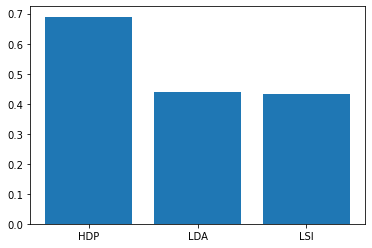

In [75]:
indices = ['HDP', 'LDA', 'LSI']
values = [hdp_coherence,lda_coherence, lsi_coherence]
plt.bar(indices, values)